In [32]:
#from src.backend import data_depositor
from src.configuration import conf
import tables
import matplotlib.pyplot as plt
import os
import numpy as np

# Basic Data Extraction
Each variable is a time series accross a single game run.

Unintuitve Variables Encodings:
* player_x_target_states:
  * Before comma: Index of current target ant
  * After comma: conquest progress
  * Negative value if there is no current target

* player_x_score_states:
  * Encodes the score popup animation
  * Before comma: Score to show
  * After comma: animation progress
  * Nan if there the popup animation is not shown
   
   
* ant_shares
  * np.nan if it is an competitive target
  * np.float64 percentage of the share of player_0 of an collaborative target

In [33]:
# Print game course data sets
output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name
files = os.listdir(output_dir_path)
for f in files:
    print(f)

gs_20-05-21_11-46-45.h5
.ipynb_checkpoints


In [34]:
def file_to_data_dict(file):
    data = file.root.data
        
    general_data = data[:, 0]
    player_data  = data[:,1:3]
    score_data   = data[:, 3]
    ant_data     = data[:,4:] 
    
    return {
        
        'player_0_scale_factors' : general_data[:, 0],
        'player_1_scale_factors' : general_data[:, 1],
        'timestamps'             : general_data[:, 2],
        
        'player_0_positions' : player_data[:, 0,: 2],
        'player_1_positions' : player_data[:, 1,: 2],

        'player_0_target_states' : player_data[:, 0, 2],
        'player_1_target_states' : player_data[:, 1, 2],
        
        'player_0_pings' : player_data[:, 0, 3],
        'player_1_pings' : player_data[:, 1, 3],

        'player_0_scores' : score_data[:, 0],
        'player_1_scores' : score_data[:, 1],
        
        'player_0_score_state' : score_data[:, 2],
        'player_1_score_state' : score_data[:, 3],

        'ant_x_positions' : ant_data[:,:, 0],
        'ant_y_positions' : ant_data[:,:, 1],
        'ant_radians'     : ant_data[:,:, 2],
        'ant_shares'      : ant_data[:,:, 3]
    }

path = output_dir_path + '/' + files[0]
file = tables.open_file(path, mode='r')
game_data = file_to_data_dict(file)


In [35]:
def check_reliability_in_time(timestamps):
    recording_duration = timestamps[-1] - timestamps[0]
    diff = np.zeros(len(timestamps)-1)
    for i in range(len(timestamps)-1):
        diff[i] = timestamps[i+1] - timestamps[i]
    print(f'Actual Value: {recording_duration}')
    print(f'Target Value: {conf.lap_time}')
    print(f'Difference in time mean actual Value: {diff.mean()}')
    print(f'Difference in time mean target Value: {1 / conf.pos_updates_ps}')
    print(f'Difference in time standard derivation: {diff.std()}')
    
    #Actual - Target Value history
    #.89
    #.77 preproduce game_states
    #.45 use exponential moving average improve time scheduling
    #.38 the same as above but no ping requests and no player movement
    #-.02 rewrote server and introduced new game scheduler with own thread,
    # no moving averages or preprocessing requiered!

check_reliability_in_time(game_data['timestamps'])

Actual Value: 19.981634378433228
Target Value: 20
Difference in time mean actual Value: 0.016665249690102774
Difference in time mean target Value: 0.016666666666666666
Difference in time standard derivation: 0.00077258915011397


In [36]:
def print_client_field_sizes(game_data):
    print('Initial client field sizes:')
    sf = [game_data['player_0_scale_factors'][0], game_data['player_1_scale_factors'][0]]
    field_server_width, field_server_height = conf.field_size
    print(f'player 1 {int(field_server_width * sf[0])} {int(field_server_height * sf[0])}')
    print(f'player 2 {int(field_server_width * sf[1])} {int(field_server_height * sf[1])}')
    
print_client_field_sizes(game_data)

Initial client field sizes:
player 1 1050 590
player 2 858 482


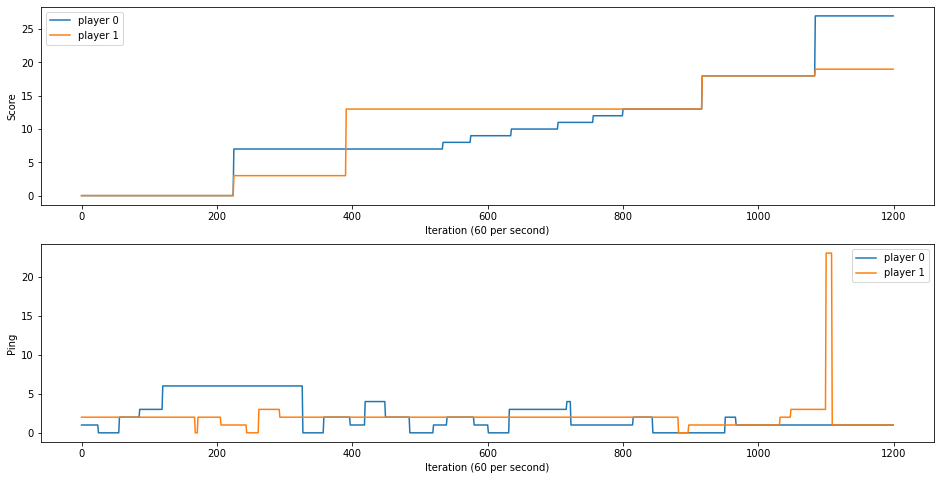

In [37]:
def plot_ping_and_score(game_data):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((16,8)))
    ax1.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax1.set_ylabel('Score')
    ax1.plot(game_data['player_0_scores'], label='player 0')
    ax1.plot(game_data['player_1_scores'], label='player 1')
    ax1.legend()
    ax2.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax2.set_ylabel('Ping')
    ax2.plot(game_data['player_0_pings'], label='player 0')
    ax2.plot(game_data['player_1_pings'], label='player 1')
    ax2.legend()
    
plot_ping_and_score(game_data)